[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/MooseNeuro/moose-notebooks/blob/main/Multi-compartmental_neuron_model.ipynb) [![Binder](./binder_logo.png)](https://mybinder.org/v2/gh/subhacom/moose-notebooks/HEAD?labpath=Multi-compartmental_neuron_model.ipynb)

In [1]:
# Only required on colab or binder!
# !pip install pymoose

# Neuronal cable with multiple compartments
Electrically speaking, a single compartment represents a single point. A standalone compartment cannot accommodate voltage gradients along neurites. Real neurons have complex tree-like structure. To take the geometry of a neuron into account, we need to put together many compartments to imitate the structure (morphology) of the neuron.

## Two-compartment model
Let us start with the simple case of a soma with an axon. We can model this with two compartments. Any current injected into the soma will raise its voltage from the resting membrane potential $Em$, but the axonal compartment will remain at $Em$ initially. Thus electric current will flow from the soma into the axon. This current will face resistance when flowing through the cytoplasm along the length of the neuron. This is the cytoplasmic resistance or axial resistance, and is represented by the field `Ra` of `Compartment` objects.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import moose

In [2]:
data = moose.Neutral('/data')
model = moose.Neutral('/model')

In [3]:
soma = moose.Compartment('/model/soma')
axon = moose.Compartment('/model/axon')

We have connect the soma to the axon somehow so the simulator can compute how much electric current is flowing from the soma into the axon (or vice versa). This requires that the voltage at the soma as well as the resistance between the soma and the axon be known when updating the axon. The computation at the soma too needs to know the voltage at the axon to figure out the current flowing out of the soma. This two way communication is achieved by a special kind of message called a shared message. 
If we want to use the soma's `Ra` for computing the current flowing from the soma into the axon, we must connect the `raxial` shared field of `soma` to `axial` dest field of `axon`.

In [4]:
moose.connect(soma, 'raxial', axon, 'axial')

<moose.SingleMsg id=5 dataIndex=0 path=/Msgs[0]/singleMsg[0]>

We can connect a pulse generator to the soma in order to deliver a current injection from 10 ms.

In [5]:
pulse = moose.PulseGen('/model/pulse')
moose.connect(pulse, 'output', soma, 'injectMsg')

<moose.SingleMsg id=5 dataIndex=1 path=/Msgs[0]/singleMsg[1]>

In [6]:
pulse.firstDelay = 10e-3
pulse.firstLevel = 10e-6
pulse.firstWidth = 1e9  # hold a constant current injection

We shall record the membrane potential at both the soma and the axon. Therefore two `Table`s must be created and connected to the two compartments.

In [7]:
vm_soma = moose.Table('/data/vm_soma')
vm_axon = moose.Table('/data/vm_axon')
moose.connect(vm_soma, 'requestOut', soma, 'getVm')
moose.connect(vm_axon, 'requestOut', axon, 'getVm')

<moose.SingleMsg id=5 dataIndex=3 path=/Msgs[0]/singleMsg[3]>

Now we can set the properties of the two compartments. For simplicity, let us keep the same values for both.

In [8]:
# Set properties of the soma compartment
soma.initVm = -70e-3
soma.Em = -70e-3
soma.Rm = 1e4
soma.Cm = 1e-7

# Set properties of the axonal compartment
axon.initVm = -70e-3
axon.Em = -70e-3
axon.Rm = 1e4
axon.Cm = 1e-7

In [9]:
runtime = 50e-3
moose.reinit()
moose.start(runtime)

Text(0, 0.5, 'Voltage (mV)')

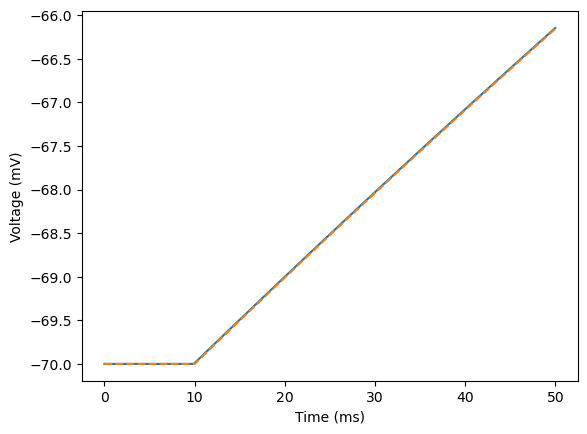

In [10]:
plt.plot(np.arange(len(vm_soma.vector)) * vm_soma.dt * 1e3, vm_soma.vector * 1e3, label='soma')
plt.plot(np.arange(len(vm_axon.vector)) * vm_axon.dt * 1e3, vm_axon.vector * 1e3, '--', label='axon')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')

The two membrane potentials seem to perfectly overlap! If we check the axial resistance of the soma, it becomes clear that the default `Ra` is too low compared to the membrane resistance. So almost all the current injected into the soma is flowing into the axon.

In [11]:
soma.Ra

1.0

Let us bring the axial resistance to the same order as the membrane resistance, so the current gets split more evenly through the soma membrane (`Rm`) and the cytoplasm (`Ra`).

In [12]:
soma.Ra = 1e4

In [13]:
runtime = 50e-3
moose.reinit()
moose.start(runtime)

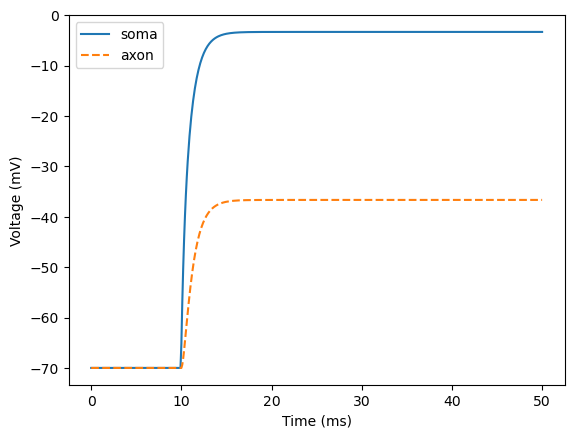

In [14]:
plt.plot(np.arange(len(vm_soma.vector)) * vm_soma.dt * 1e3, vm_soma.vector * 1e3, label='soma')
plt.plot(np.arange(len(vm_axon.vector)) * vm_axon.dt * 1e3, vm_axon.vector * 1e3, '--', label='axon')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()

## Making a longer cable with many compartments
We can investigate how a voltage deflection at the soma propagates through a neuronal cable by making a longer cable. We can put the repeating code inside a for loop. But before that, let us clean up the system. We can delete all the components we created so far and start on a clean slate:


In [16]:
moose.delete(data)
moose.delete(model)

The `delete` function deletes a moose object and all its children, along with any connections they have with other objects. This way we got rid of the earlier model and tables to record data. We re-create this structure below:

In [17]:
data = moose.Neutral('/data')
model = moose.Neutral('/model')

In [18]:
comps = []
vm_tabs = []
ncomp = 10
for ii in range(ncomp):
    comp = moose.Compartment(f'/model/comp_{ii}')
    comp.initVm = -70e-3
    comp.Em = -70e-3  
    comp.Rm = 1e5   # 100 kOhm
    comp.Cm = 1e-7  # 100 nF
    comp.Ra = 1e4   # 10 kOhm
    if len(comps) > 0:
        moose.connect(comps[-1], 'raxial', comp, 'axial')
    comps.append(comp)
    # Recording
    vm_tab = moose.Table(f'/data/vm_{ii}')
    moose.connect(vm_tab, 'requestOut', comp, 'getVm')
    vm_tabs.append(vm_tab)

Create a pulse generator and connect it to the first compartment.

In [19]:
pulse = moose.PulseGen('/model/pulse')
moose.connect(pulse, 'output', comps[0], 'injectMsg')

<moose.SingleMsg id=5 dataIndex=23 path=/Msgs[0]/singleMsg[23]>

Set the properties of the pulse generator. We are using 10 ms delay and 1 uA current injection of 1 ms duration. To avoid repetition of the pulse during the simulation, we set the second delay (`delay[1]`) to a large value.

In [20]:
pulse.delay[0] = 10e-3
pulse.level[0] = 1e-6
pulse.width[0] = 1e-3
pulse.delay[1] = 1e9   # very long time until repeating the pulse

In [21]:
runtime = 50e-3
moose.reinit()
moose.start(runtime)

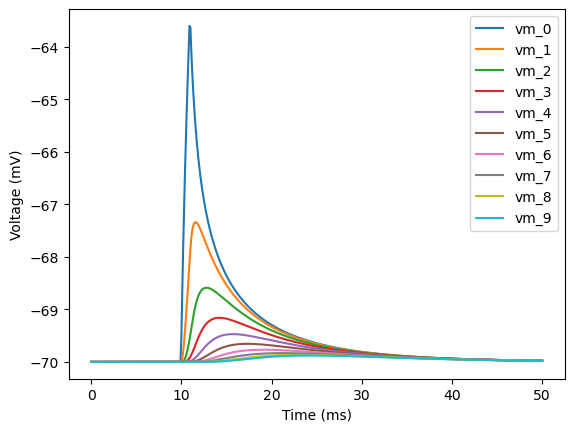

In [22]:
for tab in vm_tabs:
    plt.plot(np.arange(len(tab.vector)) * tab.dt * 1e3, tab.vector * 1e3, label=tab.name)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()

We increased the values of `Rm` and `Ra` above so that the delay in signal propagation becomes clearly visible from the plots. Both the onset of depolarization and time to reach the peak voltage increase as we go further away from the current injection site (`vm_0` is the voltage of `comp_0`, where the pulse is injected).

Also notice how the curves get smoother. This is lowpass filtering, where sharp changes in a signal get more attenuated and slower changes are passed with less attenuation. An RC circuit, as is our passive compartment model, acts as a lowpass filter.

### Exercise
Modify the values of `Rm`, `Cm`, and `Ra` and try to explain the effects on signal propagation.